# Analisis Sentiment pada Game WarThunder Mobile

## Setup

In [2]:
%pip install Sastrawi
%pip install --upgrade nltk
%pip install gensim

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import csv
import requests
from io import StringIO

# Impor baru untuk EDA dan Deep Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

2025-10-25 23:27:01.950213: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 23:27:01.951016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 23:27:01.996885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 23:27:03.121941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/rafiachn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/rafiachn/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rafiachn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Muat Data

In [5]:
data_ulasan_df = pd.read_csv('ulasan_aplikasi.csv')
data_ulasan_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1f25bd96-d953-48eb-8041-30db4f9600af,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"semenjak di update jadi sering error, server s...",1,281,1.19.2.42,2025-09-30 06:26:24,Kami menghargai masukan Anda tentang masalah s...,2025-09-30 17:08:47,1.19.2.42
1,eaf5a05c-9175-441b-b3c6-02be9480cd86,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Dari segi grafis sudah baik. →Keluhannya: 1. U...,5,369,1.19.1.39,2025-09-21 21:44:47,Kami sangat menghargai masukan Anda mengenai k...,2025-09-22 19:03:46,1.19.1.39
2,cd192b6e-c811-48d0-b4b5-67513de9974c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saran update kedepannya tambahkan detail suara...,5,46,1.19.2.42,2025-10-11 08:11:18,Kami sangat menghargai saran Anda tentang deta...,2025-10-08 18:36:43,1.19.2.42
3,521d1f05-59ea-40fb-b296-e3e08fa3c31e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,dari segi gameplay menurutku udah baguslah apa...,5,5,1.19.2.42,2025-10-11 14:42:25,Kami senang mendengar gameplay sudah memuaskan...,2025-10-20 18:49:07,1.19.2.42
4,dca04877-1b66-43dc-8ae8-f0b6c15b971f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Grafik maksimal di smartphone yang support jad...,5,153,1.18.1.11,2025-08-04 13:03:47,Kami sangat menghargai masukan Anda tentang gr...,2025-08-04 18:53:11,1.18.1.11


In [6]:
data_ulasan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12738 entries, 0 to 12737
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12738 non-null  object
 1   userName              12738 non-null  object
 2   userImage             12738 non-null  object
 3   content               12738 non-null  object
 4   score                 12738 non-null  int64 
 5   thumbsUpCount         12738 non-null  int64 
 6   reviewCreatedVersion  10073 non-null  object
 7   at                    12738 non-null  object
 8   replyContent          12678 non-null  object
 9   repliedAt             12678 non-null  object
 10  appVersion            10073 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


In [7]:
# 'score' sekarang TIDAK dihapus
columns_to_drop = ['replyContent', 'repliedAt', 'reviewCreatedVersion', 'appVersion', 'userImage']
data_bersih_df = data_ulasan_df.drop(columns=columns_to_drop)

# Pastikan 'score' dan 'content' ada
print(data_bersih_df.head())

                               reviewId         userName  \
0  1f25bd96-d953-48eb-8041-30db4f9600af  Pengguna Google   
1  eaf5a05c-9175-441b-b3c6-02be9480cd86  Pengguna Google   
2  cd192b6e-c811-48d0-b4b5-67513de9974c  Pengguna Google   
3  521d1f05-59ea-40fb-b296-e3e08fa3c31e  Pengguna Google   
4  dca04877-1b66-43dc-8ae8-f0b6c15b971f  Pengguna Google   

                                             content  score  thumbsUpCount  \
0  semenjak di update jadi sering error, server s...      1            281   
1  Dari segi grafis sudah baik. →Keluhannya: 1. U...      5            369   
2  Saran update kedepannya tambahkan detail suara...      5             46   
3  dari segi gameplay menurutku udah baguslah apa...      5              5   
4  Grafik maksimal di smartphone yang support jad...      5            153   

                    at  
0  2025-09-30 06:26:24  
1  2025-09-21 21:44:47  
2  2025-10-11 08:11:18  
3  2025-10-11 14:42:25  
4  2025-08-04 13:03:47  


In [8]:
data_bersih_df.duplicated().sum()

np.int64(0)

In [9]:
data_bersih_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12738 entries, 0 to 12737
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       12738 non-null  object
 1   userName       12738 non-null  object
 2   content        12738 non-null  object
 3   score          12738 non-null  int64 
 4   thumbsUpCount  12738 non-null  int64 
 5   at             12738 non-null  object
dtypes: int64(2), object(4)
memory usage: 597.2+ KB


## Preprocessing dan Analisis Leksikon

In [10]:
# --- Langkah 1: Muat kamus normalisasi utama dari Slang_indo.txt ---
kamus_slang = {}
file_referensi = "Slang_indo.txt"
try:
    with open(file_referensi, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) == 2:
                kamus_slang[parts[0]] = parts[1]
    print(f"Berhasil memuat {len(kamus_slang)} kata referensi dari {file_referensi}")
except Exception as e:
    print(f"Error reading {file_referensi}: {e}")

# --- Langkah 2: Muat wtm_slang.txt dan tambahkan kata yang belum ada ---
file_target = "wtm_slang.txt"
kata_tambahan = 0
kata_sudah_ada = 0

try:
    with open(file_target, 'r', encoding='utf-8') as f:
        for line in f:
            kata = line.strip()
            if not kata:  # Lewati baris kosong
                continue
            
            # Cek apakah kata sudah ada di kamus
            if kata not in kamus_slang:
                kamus_slang[kata] = kata
                kata_tambahan += 1
            else:
                kata_sudah_ada += 1
                
    print(f"Berhasil memproses {file_target}:")
    print(f"  - {kata_sudah_ada} kata sudah memiliki aturan normalisasi dari {file_referensi}.")
    print(f"  - {kata_tambahan} kata baru ditambahkan ke kamus.")
    print(f"Total {len(kamus_slang)} kata dalam kamus slang.")

except Exception as e:
    print(f"Error reading {file_target}: {e}")


# --- Siapkan stopwords (Termasuk perbaikan untuk kata sentimen) ---
listStopwords_nltk = set(stopwords.words('indonesian'))
listStopwords_english = set(stopwords.words('english'))

# Tentukan kata-kata penting untuk sentimen (negasi, intensifier)
kata_penting_sentimen = {"tidak", "bukan", "jangan", "sekali", "banget", "sangat"}

# Hapus kata-kata penting dari daftar stopwords
listStopwords = (listStopwords_nltk | listStopwords_english) - kata_penting_sentimen
listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
print(f"\nTotal stopwords: {len(listStopwords)}.")


# --- Fungsi preprocess_text (Tidak berubah) ---
def preprocess_text(text):
    # 1. Cleaning
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\\s]', '', text)
    text = re.sub(r"http\\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    text = re.sub(
        "[\"\n\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002700-\U000027BF\U0001F900-\U0001F9FF\U00002600-\U000026FF\U00002B00-\U00002BFF]+",
        '', text)
    
    # 2. Casefolding
    text = text.lower()
    
    # 3. Normalisasi Slang & Tokenizing
    words = word_tokenize(text)
    fixed_words = []
    for word in words:
        fixed_words.append(kamus_slang.get(word, word))
    
    # 4. Filtering (Stopword Removal)
    filtered_words = []
    for txt in fixed_words:
        if txt not in listStopwords:
            filtered_words.append(txt)
    
    # 5. Gabung kembali ke kalimat
    sentence = ' '.join(filtered_words)
    
    return filtered_words, sentence

Berhasil memuat 1250 kata referensi dari Slang_indo.txt
Berhasil memproses wtm_slang.txt:
  - 47 kata sudah memiliki aturan normalisasi dari Slang_indo.txt.
  - 203 kata baru ditambahkan ke kamus.
Total 1453 kata dalam kamus slang.

Total stopwords: 965.


In [11]:
hasil_preprocess = data_bersih_df['content'].apply(preprocess_text)

data_bersih_df['text_filtered'] = hasil_preprocess.apply(lambda x: x[0])
data_bersih_df['text_final'] = hasil_preprocess.apply(lambda x: x[1])

data_bersih_df[['content', 'text_filtered', 'text_final']].head()

,content,text_filtered,text_final
0,"semenjak di update jadi sering error, server s...","[semenjak, update, error, server, bermasalah, ...",semenjak update error server bermasalah amunis...
1,Dari segi grafis sudah baik. →Keluhannya: 1. U...,"[segi, grafis, keluhannya, update, kedepannya,...",segi grafis keluhannya update kedepannya tolon...
2,Saran update kedepannya tambahkan detail suara...,"[saran, update, kedepannya, tambahkan, detail,...",saran update kedepannya tambahkan detail suara...
3,dari segi gameplay menurutku udah baguslah apa...,"[segi, gameplay, menurutku, baguslah, setalah,...",segi gameplay menurutku baguslah setalah ditam...
4,Grafik maksimal di smartphone yang support jad...,"[grafik, maksimal, smartphone, support, terbai...",grafik maksimal smartphone support terbaik gam...


In [12]:
kamus_positif = dict()
response_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response_pos.status_code == 200:
    reader_pos = csv.reader(StringIO(response_pos.text), delimiter=',')
    for row in reader_pos:
        kamus_positif[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

kamus_negatif = dict()
response_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response_neg.status_code == 200:
    reader_neg = csv.reader(StringIO(response_neg.text), delimiter=',')
    for row in reader_neg:
        kamus_negatif[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [13]:
def hitung_skor_sentimen(list_kata):
    score = 0
    # Daftar kata-kata negasi yang umum
    negasi = ['tidak', 'bukan', 'jangan', 'ga', 'gak', 'tiada', 'bkn', 'tdk']
    
    skip_next = False
    for i in range(len(list_kata)):
        # Lewati kata ini jika sudah di-handle oleh kata negasi sebelumnya
        if skip_next:
            skip_next = False
            continue
            
        word = list_kata[i]
        
        # Cek apakah kata ini adalah negasi DAN bukan kata terakhir
        if word in negasi and (i + 1) < len(list_kata):
            next_word = list_kata[i+1]
            
            # Jika kata berikutnya positif (misal "tidak BAGUS")
            if next_word in kamus_positif:
                # Balik skornya menjadi negatif
                score -= kamus_positif.get(next_word, 0)
                skip_next = True # Tandai untuk melewati kata berikutnya
                
            # Jika kata berikutnya negatif (misal "tidak JELEK")
            elif next_word in kamus_negatif:
                # Balik skornya menjadi positif (negatif * -1 = positif)
                score -= kamus_negatif.get(next_word, 0)
                skip_next = True # Tandai untuk melewati kata berikutnya
            
            # Jika kata berikutnya tidak ada di kamus, anggap negasi biasa
            else:
                score -= 1 # Beri penalti kecil untuk negasi
        
        # Jika bukan kata negasi, proses seperti biasa
        else:
            score += kamus_positif.get(word, 0)
            score += kamus_negatif.get(word, 0)
            
    kata_negatif_pasti = ["bug","burik","ampas","lemot","error", "jelek", "parah", "eror"]
    
    # Aturan ini akan menimpa skor jika kata-kata ini muncul TANPA negasi
    if any(w in kata_negatif_pasti for w in list_kata) and not any(n in list_kata for n in negasi):
        polarity = 'negative'
    
    # Logika penentuan polaritas
    else:
        if score > 0:
            polarity = 'positive'
        elif score < 0:
            polarity = 'negative'
        else:
            polarity = 'neutral'
    
    return score, polarity

In [14]:
# Menerapkan fungsi baru 'hitung_skor_sentimen'
hasil_analisis = data_bersih_df['text_filtered'].apply(hitung_skor_sentimen)
hasil_analisis_list = list(zip(*hasil_analisis))

data_bersih_df['polarity_score'] = hasil_analisis_list[0]
data_bersih_df['polarity'] = hasil_analisis_list[1]

print(data_bersih_df['polarity'].value_counts())

polarity
negative    5655
positive    4540
neutral     2543
Name: count, dtype: int64


## EDA (Exploratory Data Analysis)

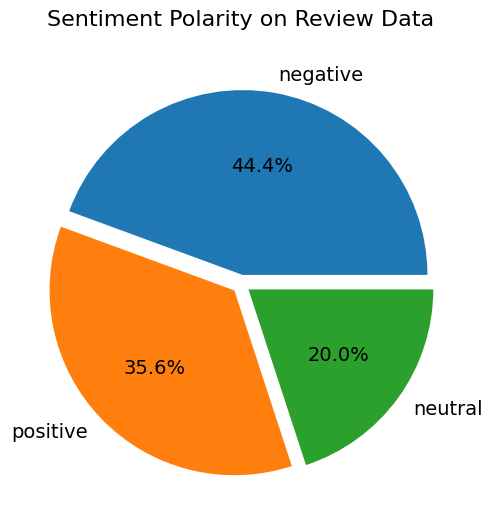

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in data_bersih_df['polarity'].value_counts()]
labels = list(data_bersih_df['polarity'].value_counts().index)
explode = [0.05] * len(labels)

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

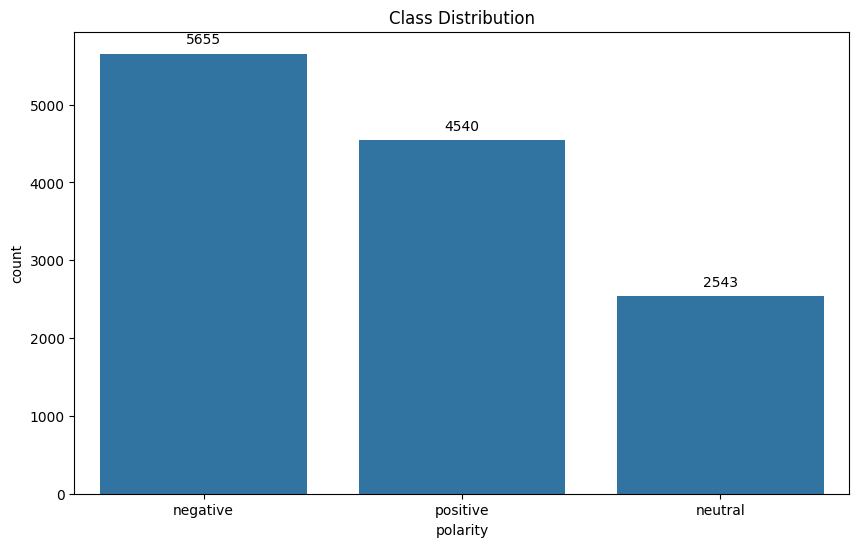

In [16]:
plt.figure(figsize=(10, 6))

# **PERUBAHAN:** Menggunakan 'data_bersih_df'
class_dist_plot = sns.countplot(x='polarity', data=data_bersih_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')
plt.show()

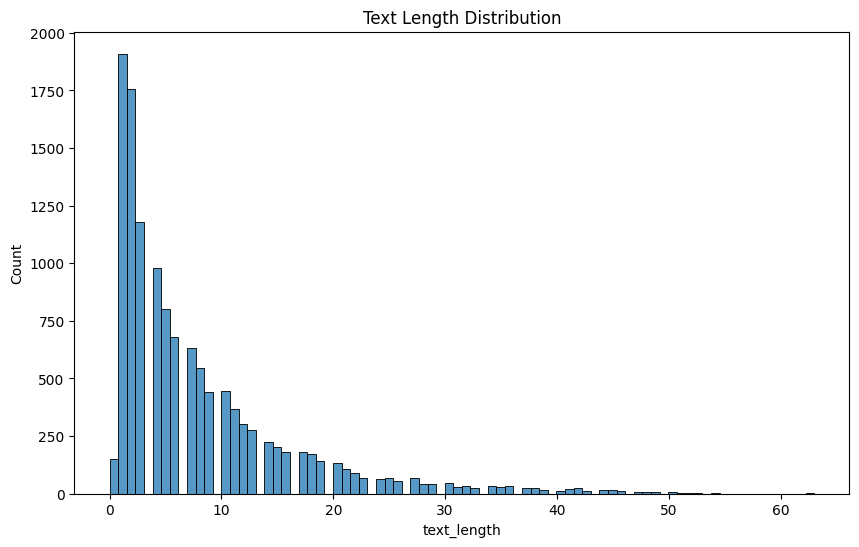

In [17]:
plt.figure(figsize=(10, 6))

data_bersih_df['text_length'] = data_bersih_df['text_final'].apply(lambda x: len(x.split()))
sns.histplot(data_bersih_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

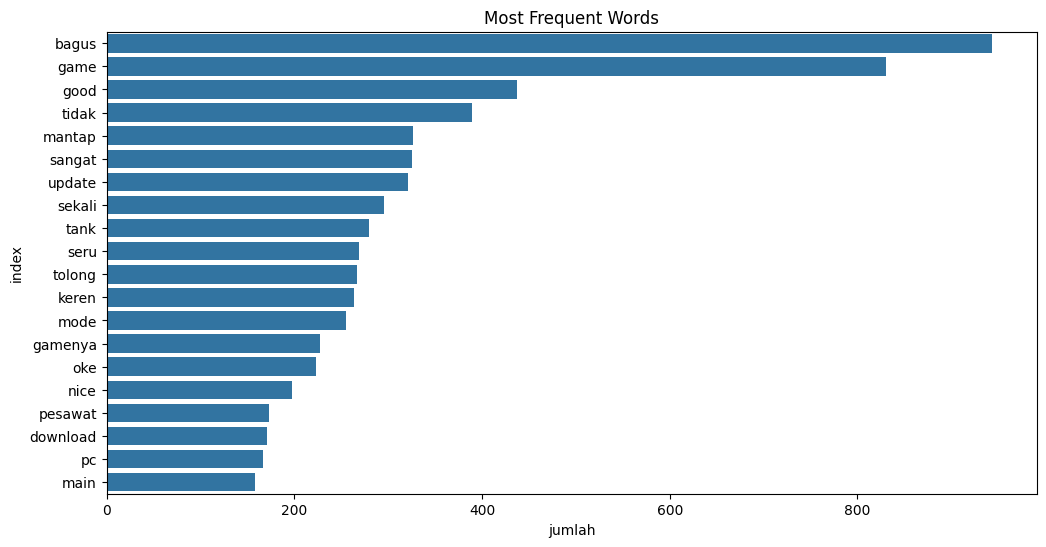

In [18]:
plt.figure(figsize=(12, 6))

vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(data_bersih_df['text_final'])
tfidf_df = pd.DataFrame(X_vec.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

## Model Deep Learning (LSTM)

In [19]:
X = data_bersih_df['text_final']
y = data_bersih_df['polarity']

# Encode label menjadi angka 0,1,2
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Urutan kelas di LabelEncoder:", le.classes_)

# Split data train-test dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

Urutan kelas di LabelEncoder: ['negative' 'neutral' 'positive']


In [20]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}

print("Class Weights:", class_weight_dict)

Class Weights: {np.int64(0): np.float64(0.7508104921898026), np.int64(1): np.float64(1.6699442805637497), np.int64(2): np.float64(0.9352055800293686)}


In [21]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 kelas: positive, negative, neutral
])


/media/rafiachn/D/Workspace Code/Code Study/Python/DLCOURSE/Proyek1/env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-10-25 23:27:05.381610: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Sesuai untuk label integer (0,1,2)
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.6278 - loss: 0.8027 - val_accuracy: 0.8363 - val_loss: 0.4729
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8725 - loss: 0.4032 - val_accuracy: 0.8626 - val_loss: 0.3965
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9189 - loss: 0.2585 - val_accuracy: 0.8619 - val_loss: 0.4245
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.9351 - loss: 0.2151 - val_accuracy: 0.8603 - val_loss: 0.4537
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.9461 - loss: 0.1711 - val_accuracy: 0.8556 - val_loss: 0.5068


In [24]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

report_dict = classification_report(
    y_test, y_pred,
    target_names=le.classes_,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=le.classes_,
    columns=le.classes_
)

print("Classification Report:")
display(report_df)

print("\nConfusion Matrix:")
display(cm_df)

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Classification Report:


,precision,recall,f1-score,support
negative,0.851012,0.929266,0.888419,1131.000000
neutral,0.838235,0.783890,0.810152,509.000000
positive,0.893668,0.823789,0.857307,908.000000
accuracy,0.862637,0.862637,0.862637,0.862637
macro avg,0.860972,0.845648,0.851959,2548.000000
weighted avg,0.863660,0.862637,0.861697,2548.000000



Confusion Matrix:


,negative,neutral,positive
negative,1051,33,47
neutral,68,399,42
positive,116,44,748


In [25]:
train_loss, train_acc = model.evaluate(X_train_pad, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Train Accuracy: 0.9298, Train Loss: 0.2190
Test Accuracy: 0.8626, Test Loss: 0.3965


In [26]:
!pip freeze > requirements.txt